<h1>The5Outliers - <span style="background: linear-gradient(to right, #28649c, #1dc2b1); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span>: why so many players pass through World regions to reach their target</h1>

In [255]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [262]:
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import numpy as np

import config
from src.utils.HTMLParser import HTMLParser
from src.data.data_loader import *
from src.utils.helpers import *
from src.models.networks import *
from src.models.similarity_matrices import *
from src.models.markov_chains import *

parser = HTMLParser()
parser.load_pickle()

[autoreload of src.utils.helpers failed: Traceback (most recent call last):
  File "/Users/mariannescoglio/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mariannescoglio/anaconda3/envs/ada/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/mariannescoglio/anaconda3/envs/ada/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/mariannescoglio/Desktop/MA3/ADA/project/ada-2024-project-the5outliers/src/utils/helpers.py", line 695, in <module>
    def plot_position_line(S_T_fin_percentages_norm_steps, S_T_op

In [56]:
# Delete for final version?
# Compute and save all embending, similarity matrices and parsed articles
#compute_save_all()

# 0. Data preprocessing and loading

We use the `read_all()` function to load, clean, and enhance the data with useful features for analysis. It combines multiple data sources, performs preprocessing, and computes additional features for articles and user paths.

## Preprocessed Dataframes:

- `df_article_names`: Valid article names, that is without special characters and discardig any invalid articles (e.g. non-Wikispeedia articles or with missing categories).
- `df_html_stats`: Gathers wikispedia page statistics like number of links, link density, and structural information from the HTML version of each article.
- `df_categories`: Article categories and sub categories.
- `df_links`: Links inward and outward between articles.
- `df_shortest_path_length`: Matrix of shortest paths lengths possible between two articles.
- `df_unfinished` and `df_finished`: Cleaned paths with computed features.
- `df_sm` and `df_scat`: Matrices for semantic and category similarity.
- `df_article`: Dataframe with article-level features.

In [57]:
# Load and preprocess the data
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'The', 'Long peper', 'Charlottes web', 'The Rock', 'Adolph Hitler', 'Rss', 'Netbook', 'Podcast', 'Sportacus', 'English', 'Rat', 'Great', 'Christmas', 'Western Australia', 'Usa', 'Pikachu', 'Bogota', 'Kashmir', 'Fats', 'Test', 'Macedonia', 'Mustard', 'Black ops 2', ' Zebra', 'Georgia'}
Invalid articles found in path: {'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License', 'Pikachu', 'Private Peaceful', 'Local community'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Pikachu', 'Local community', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License'}
Number of rows after filtering: 51196


## Key Modifications

### 1. Categories:
Each category is organized into multiple sub-levels, with a hierarchical depth of up to 3 levels. We observe that some articles are associated with multiple categories, highlighting overlaps and shared connections within the dataset. For our analysis we need to have only one category corresponding to each article, thus we choose to keep the most specific one.

Attributing the **first level category** based on the one **with fewer total articles** helps prioritize specialization over generality. 

Categories with fewer total articles are typically more specific, while those with higher counts cover broader topics. By focusing on the category with fewer articles, we ensure the article’s primary focus is on a unique or specialized perspective, providing a clearer thematic assignment. This method promotes a balanced classification system, ensuring articles are categorized accurately without being overshadowed by more general categories.

- For example, a category like **"Science"** may encompass a wide range of topics, while **"IT"** might be more specialized.

In [58]:
df_categories_original = read_categories()
labels, parents, values, ids = create_treemap_data(df_categories_original, show_articles=True)
fig = go.Figure(go.Treemap(
    labels=labels,
    parents=parents,
    values=values,
    ids=ids,
    textfont=dict(size=18),
    branchvalues='total'  # Ensures proportional sizing by summation of children
))
fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

print(f'We have {df_categories_original["level_1"].unique().size} distinct level 1 categories.')

We have 15 distinct level 1 categories.


- Each category is organized into multiple sub-levels, with a hierarchical depth of up to 3 levels.

#### Articles with Multiples Categories

- First we count the numbers of articles with multiples categories:

In [59]:
# Count the number of articles with multiples categories
df_categories_original.groupby("article")["article"].size().value_counts()

article
1    3986
2     590
3       8
Name: count, dtype: int64

- But if we constrain it only to different type of level 1 categories, it is reduced to :

In [60]:
# Count the number of unique level 1 categories per article
df_categories_original.groupby("article")["level_1"].nunique().value_counts()

level_1
1    4078
2     505
3       1
Name: count, dtype: int64

### 2. Article Features:
- **In-Degree**: of an article corresponds to the number of links on other pages targetting an article 
    - Some articles have no articles leading to it.
- **Out-Degree**: of an article corresponds to the number of links towards other pages on this article
    - Some articles lead to no other articles.
- **HTML Stats**: Structural details like the number of links per article.
    - Links do not consider duplicates inside the page (each link is considered to appear once) but this is relaxed with the HTML parsing.
- **Categories**: Assigns the most specific category to each article.

### 3. Path Features:
Metrics computed for user navigation paths:

- **Path Length**: Number of articles in a user's path.
- **Back-Clicks**: How many times users revisit previous articles.
- **Cosine Similarity**: Semantic similarity between source and target articles.
- **Shortest Path**: Length of the shortest path possible between the source and target articles.
- **Category Similarity**: Category similarity between the categories of the source and target articles.

## 1 Find Voyages

The goal of our research is to explore the role and significance of World Regions in user behavior while playing Wikispeedia. To achieve this, we first extract articles corresponding to *World Regions*.  
Fortunately, articles are categorized, so we gather those under *'Countries'* and relevant subcategories of *'Geography'* such as *'Geography of Asia'*. These articles are grouped into a new category called *'World Regions'*, while remaining *'Geography'* articles are keeping the same category.

In [61]:
world_regions_categories = ['Geography of Great Britain', 'Geography of Asia', 'Geography of Oceania Australasia', 'North American Geography', 'European Geography', 'African Geography', 'Central and South American Geography', 'Antarctica', 'Geography of the Middle East', 'African Countries', 'Countries']
df_categories = assign_world_region_categories(df_categories, world_regions_categories)

- Below we can observe the new distributions of articles categories after the most specific category and the assignement of the new categorgories world regions.

In [62]:
labels_filtered, parents_filtered, values_filtered, ids_filtered = create_treemap_data(df_categories, show_articles=True)

fig = go.Figure(go.Treemap(
    labels=labels_filtered,
    parents=parents_filtered,
    values=values_filtered,
    ids=ids_filtered,
    textfont=dict(size=18),
    branchvalues='total'  # Ensures proportional sizing by summation of children
))
fig.update_layout(margin=dict(t=50, l=10, r=10, b=5), title="Category Distribution in Articles (Only the most specific category is shown for each article)")
fig.show()

### Sort games into voyage or not-voyage & assign the new category *'World Regions'*

A <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyage</span> is defined as a path game where neither the source nor the target is in **World Regions**, but the path includes at least one article from this category.

In [63]:
# Sort paths into voyage and non-voyage
df_finished = game_voyage_sorting(df_finished, df_categories)
df_unfinished = game_voyage_sorting(df_unfinished, df_categories)

# Assign the categories "World Regions" to the concerned articles
category_map = dict(zip(df_categories["article"], df_categories["level_1"]))
df_article["category"] = df_article["article"].map(category_map)

In [64]:
# Count the voyages 
voyage_count = (df_finished['Wikispeedia_Voyage'] == 1).sum() + (df_unfinished['Wikispeedia_Voyage'] == 1).sum()
non_voyage_count = (df_finished['Wikispeedia_Voyage'] == 0).sum() + (df_unfinished['Wikispeedia_Voyage'] == 0).sum()

print('Out of the ', len(df_finished)+len(df_unfinished), ' finished and unfinished games : ')
print('  - ', voyage_count, ' are voyages')
print('  - ', non_voyage_count, ' are not')

Out of the  75905  finished and unfinished games : 
  -  26026  are voyages
  -  49879  are not


We immediately see that <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyage</span> are very commun since they are approximately one third of the paths.

In [65]:
#concatenate all games in a dataframe and plot the sankey diagram 
df_merged = pd.concat([df_finished, df_unfinished], ignore_index=True, sort=False)
sankey_fig = plot_sankey_voyage(df_merged, background_color="white")

In [66]:
#sankey_fig.write_html('figures/sankey.html',include_plotlyjs=False)

In [68]:
import plotly.io 

plotly.io.to_html(sankey_fig, include_plotlyjs=False)

ValueError: 
The fig parameter must be a dict or Figure.
    Received value of type <class 'str'>: <div>                            <div id="2b71689f-6920-4e7e-8dff-4acf71b61de7" class="plotly-graph-div" style="height:100%; width:100%;"></div>            <script type="text/javascript">                                    window.PLOTLYENV=window.PLOTLYENV || {};                                    if (document.getElementById("2b71689f-6920-4e7e-8dff-4acf71b61de7")) {                    Plotly.newPlot(                        "2b71689f-6920-4e7e-8dff-4acf71b61de7",                        [{"link":{"color":["rgba(75, 75, 75, 0.3)","rgba(75, 75, 75, 0.3)","rgba(44, 181, 174, 0.3)","rgba(75, 75, 75, 0.3)","rgba(75, 75, 75, 0.3)","rgba(44, 181, 174, 0.3)"],"source":[0,1,1,3,3,2],"target":[3,3,2,4,5,5],"value":[10903,38976,26026,15318,34561,26026]},"node":{"color":["#2CB5AE","#4b4b4b","#2CB5AE","#4b4b4b","#2CB5AE","#4b4b4b"],"label":["Source is a World Regions","Source is not a World Regions","Voyages","Non-Voyages","Target is a World Regions","Target is not a World Regions"],"line":{"color":"white","width":0},"pad":20,"thickness":20},"type":"sankey"}],                        {"font":{"size":10},"paper_bgcolor":"white","plot_bgcolor":"white","template":{"data":{"barpolar":[{"marker":{"line":{"color":"#E5ECF6","width":0.5},"pattern":{"fillmode":"overlay","size":10,"solidity":0.2}},"type":"barpolar"}],"bar":[{"error_x":{"color":"#2a3f5f"},"error_y":{"color":"#2a3f5f"},"marker":{"line":{"color":"#E5ECF6","width":0.5},"pattern":{"fillmode":"overlay","size":10,"solidity":0.2}},"type":"bar"}],"carpet":[{"aaxis":{"endlinecolor":"#2a3f5f","gridcolor":"white","linecolor":"white","minorgridcolor":"white","startlinecolor":"#2a3f5f"},"baxis":{"endlinecolor":"#2a3f5f","gridcolor":"white","linecolor":"white","minorgridcolor":"white","startlinecolor":"#2a3f5f"},"type":"carpet"}],"choropleth":[{"colorbar":{"outlinewidth":0,"ticks":""},"type":"choropleth"}],"contourcarpet":[{"colorbar":{"outlinewidth":0,"ticks":""},"type":"contourcarpet"}],"contour":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"type":"contour"}],"heatmapgl":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"type":"heatmapgl"}],"heatmap":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"type":"heatmap"}],"histogram2dcontour":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"type":"histogram2dcontour"}],"histogram2d":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"type":"histogram2d"}],"histogram":[{"marker":{"pattern":{"fillmode":"overlay","size":10,"solidity":0.2}},"type":"histogram"}],"mesh3d":[{"colorbar":{"outlinewidth":0,"ticks":""},"type":"mesh3d"}],"parcoords":[{"line":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"parcoords"}],"pie":[{"automargin":true,"type":"pie"}],"scatter3d":[{"line":{"colorbar":{"outlinewidth":0,"ticks":""}},"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scatter3d"}],"scattercarpet":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scattercarpet"}],"scattergeo":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scattergeo"}],"scattergl":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scattergl"}],"scattermapbox":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scattermapbox"}],"scatterpolargl":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scatterpolargl"}],"scatterpolar":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scatterpolar"}],"scatter":[{"fillpattern":{"fillmode":"overlay","size":10,"solidity":0.2},"type":"scatter"}],"scatterternary":[{"marker":{"colorbar":{"outlinewidth":0,"ticks":""}},"type":"scatterternary"}],"surface":[{"colorbar":{"outlinewidth":0,"ticks":""},"colorscale":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"type":"surface"}],"table":[{"cells":{"fill":{"color":"#EBF0F8"},"line":{"color":"white"}},"header":{"fill":{"color":"#C8D4E3"},"line":{"color":"white"}},"type":"table"}]},"layout":{"annotationdefaults":{"arrowcolor":"#2a3f5f","arrowhead":0,"arrowwidth":1},"autotypenumbers":"strict","coloraxis":{"colorbar":{"outlinewidth":0,"ticks":""}},"colorscale":{"diverging":[[0,"#8e0152"],[0.1,"#c51b7d"],[0.2,"#de77ae"],[0.3,"#f1b6da"],[0.4,"#fde0ef"],[0.5,"#f7f7f7"],[0.6,"#e6f5d0"],[0.7,"#b8e186"],[0.8,"#7fbc41"],[0.9,"#4d9221"],[1,"#276419"]],"sequential":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]],"sequentialminus":[[0.0,"#0d0887"],[0.1111111111111111,"#46039f"],[0.2222222222222222,"#7201a8"],[0.3333333333333333,"#9c179e"],[0.4444444444444444,"#bd3786"],[0.5555555555555556,"#d8576b"],[0.6666666666666666,"#ed7953"],[0.7777777777777778,"#fb9f3a"],[0.8888888888888888,"#fdca26"],[1.0,"#f0f921"]]},"colorway":["#636efa","#EF553B","#00cc96","#ab63fa","#FFA15A","#19d3f3","#FF6692","#B6E880","#FF97FF","#FECB52"],"font":{"color":"#2a3f5f"},"geo":{"bgcolor":"white","lakecolor":"white","landcolor":"#E5ECF6","showlakes":true,"showland":true,"subunitcolor":"white"},"hoverlabel":{"align":"left"},"hovermode":"closest","mapbox":{"style":"light"},"paper_bgcolor":"white","plot_bgcolor":"#E5ECF6","polar":{"angularaxis":{"gridcolor":"white","linecolor":"white","ticks":""},"bgcolor":"#E5ECF6","radialaxis":{"gridcolor":"white","linecolor":"white","ticks":""}},"scene":{"xaxis":{"backgroundcolor":"#E5ECF6","gridcolor":"white","gridwidth":2,"linecolor":"white","showbackground":true,"ticks":"","zerolinecolor":"white"},"yaxis":{"backgroundcolor":"#E5ECF6","gridcolor":"white","gridwidth":2,"linecolor":"white","showbackground":true,"ticks":"","zerolinecolor":"white"},"zaxis":{"backgroundcolor":"#E5ECF6","gridcolor":"white","gridwidth":2,"linecolor":"white","showbackground":true,"ticks":"","zerolinecolor":"white"}},"shapedefaults":{"line":{"color":"#2a3f5f"}},"ternary":{"aaxis":{"gridcolor":"white","linecolor":"white","ticks":""},"baxis":{"gridcolor":"white","linecolor":"white","ticks":""},"bgcolor":"#E5ECF6","caxis":{"gridcolor":"white","linecolor":"white","ticks":""}},"title":{"x":0.05},"xaxis":{"automargin":true,"gridcolor":"white","linecolor":"white","ticks":"","title":{"standoff":15},"zerolinecolor":"white","zerolinewidth":2},"yaxis":{"automargin":true,"gridcolor":"white","linecolor":"white","ticks":"","title":{"standoff":15},"zerolinecolor":"white","zerolinewidth":2}}},"title":{"font":{"size":14},"text":"Voyage and Non-Voyage Paths","x":0.5}},                        {"responsive": true}                    )                };                            </script>        </div>

# 2. Article features

## 2.1.a. Distributions of words, links, and categories in articles

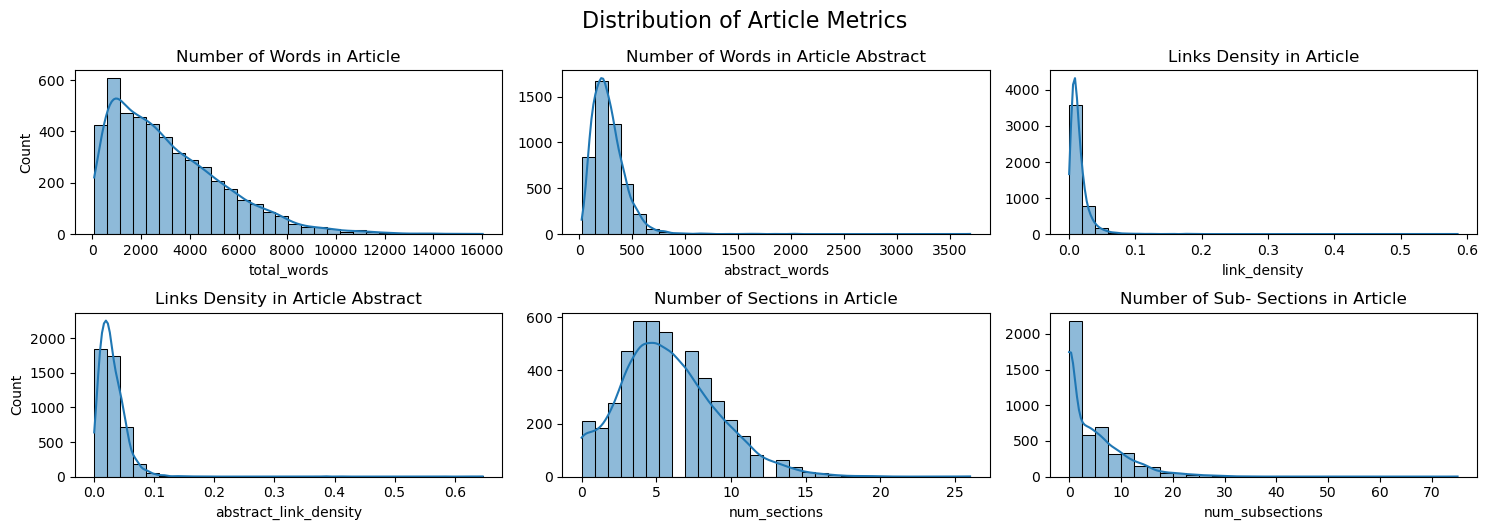

In [69]:
#TODO: big big plot voyage/non-voyage

metrics = [
    ("total_words", "Number of Words in Article"),
    ("abstract_words", "Number of Words in Article Abstract"),
    ("link_density", "Links Density in Article"),
    ("abstract_link_density", "Links Density in Article Abstract"),
    ("num_sections", "Number of Sections in Article"),
    ("num_subsections", "Number of Sub- Sections in Article")
]

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

# Loop through metrics to create histograms
for i, (metric, title) in enumerate(metrics):
    row, col = divmod(i, 3)
    sn.histplot(df_article, x=metric, bins=30, kde=True, ax=ax[row, col])
    ax[row, col].set_title(title)
    if col == 1 or col == 2:
        ax[row, col].set_ylabel('')

plt.tight_layout()
plt.suptitle("Distribution of Article Metrics", y=1.05, fontsize=16)
plt.show()

Results : The data is right-skewed for most of metrics, indicating that while most articles adhere to certain standards of complexity and length, a small subset stands out as particularly detailed or interconnected.

## 2.1.b Articles Complexity

Which categories feature the most complex articles? To answer this question, let’s identify the most complex articles and the categories they belong to. We define complexity based on factors such as the number of words, links, and sections within each article.

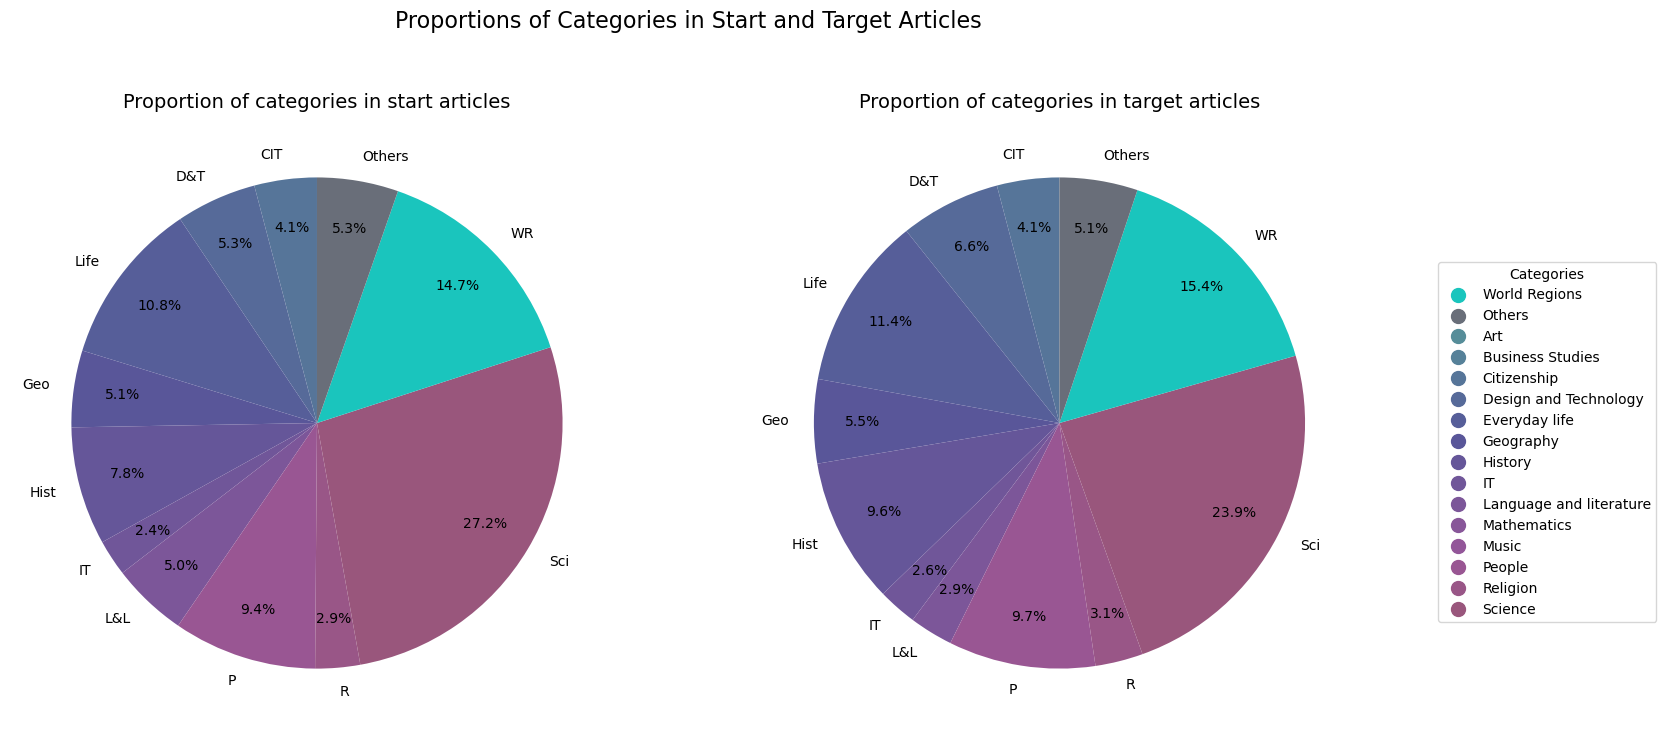

In [70]:
#add count of start and target in df_articles
count_start_and_target_per_articles(df_finished, df_unfinished, df_article)

#plot 
plot_proportion_category_start_stop_pies(
    df_article=df_article,
    palette=config.PALETTE_CATEGORY_DICT_COLORS,
    abbreviations=config.CATEGORY_ABBREVIATIONS,
    threshold=2.3
)

"Science" and "World Regions" categories are the most prevalent categories in both start and end articles, indicating their significant representation.

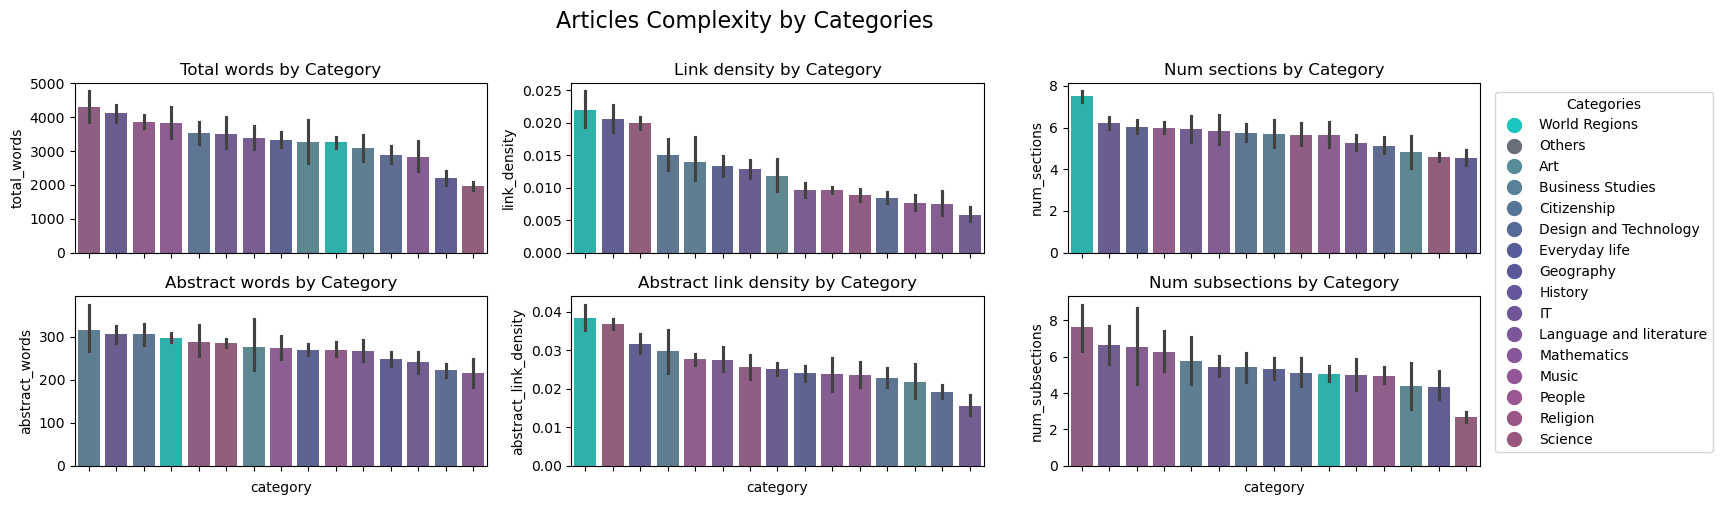

In [71]:
metrics = [
    "total_words", "link_density", "num_sections",
    "abstract_words", "abstract_link_density", "num_subsections"
]

plot_metrics_by_category(df_article, metrics, config.PALETTE_CATEGORY_DICT_COLORS, config.CATEGORY_ABBREVIATIONS)

#TODO : add abreviations on x axis anf in legend 

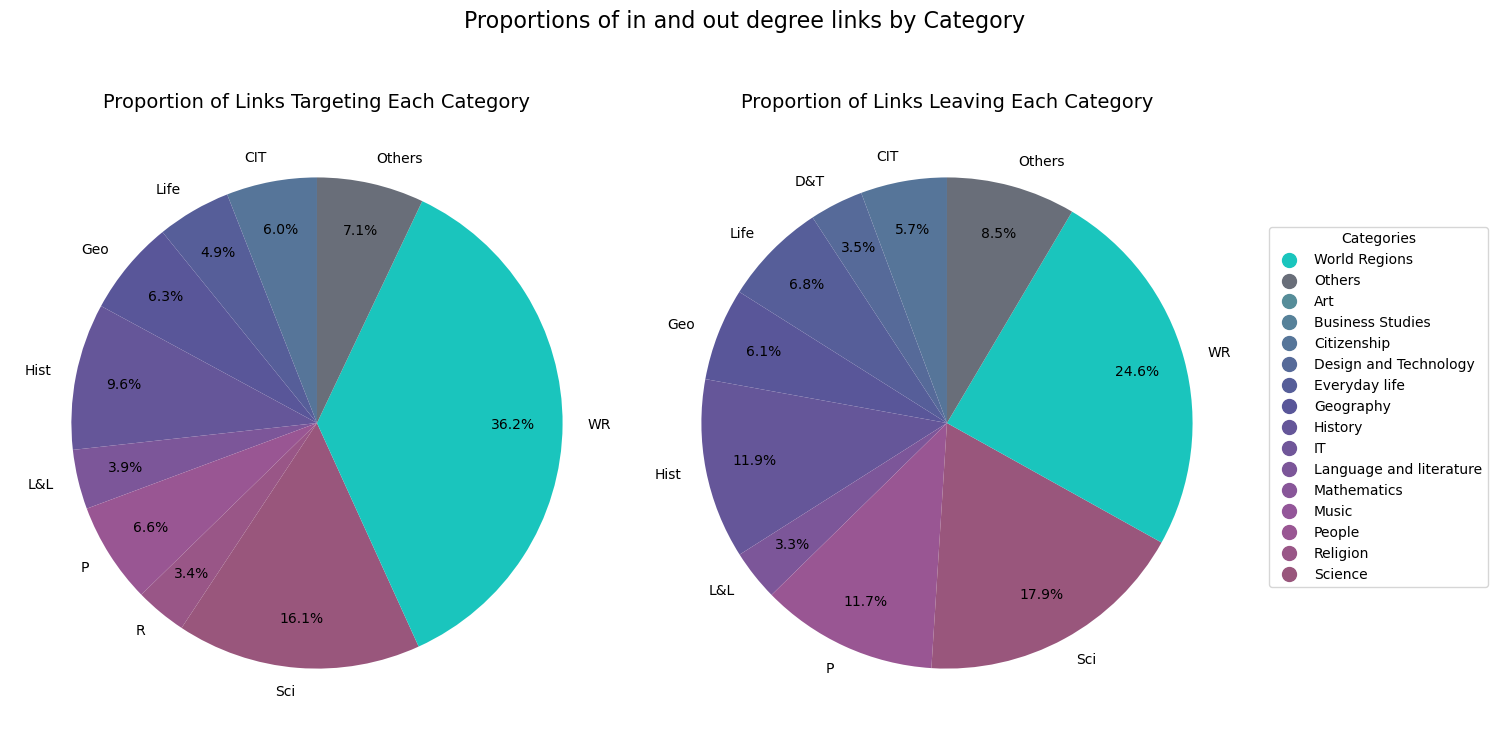

In [72]:
plot_proportions_of_in_and_out_degree_in_categories(
    df=df_article,
    palette=config.PALETTE_CATEGORY_DICT_COLORS,
    abbreviations=config.CATEGORY_ABBREVIATIONS
)

World Regions articles are highly represented in the network, being the category with the highest number of incoming and outgoing links.

Results : The category "World Regions" stands out as a particularly complex topic, characterized by articles with the highest link density and the greatest number of category levels.

## 2.1.c Articles Popularity and Connectivity

Is there a correlation between the number of links in an article and the frequency with which people interact with it in the game? Does this depend more on the in-degree or out-degree of the links? And is there a significant difference between the in-degree and out-degree of links? We will compare and investigate these factors to understand their impact on article interaction.

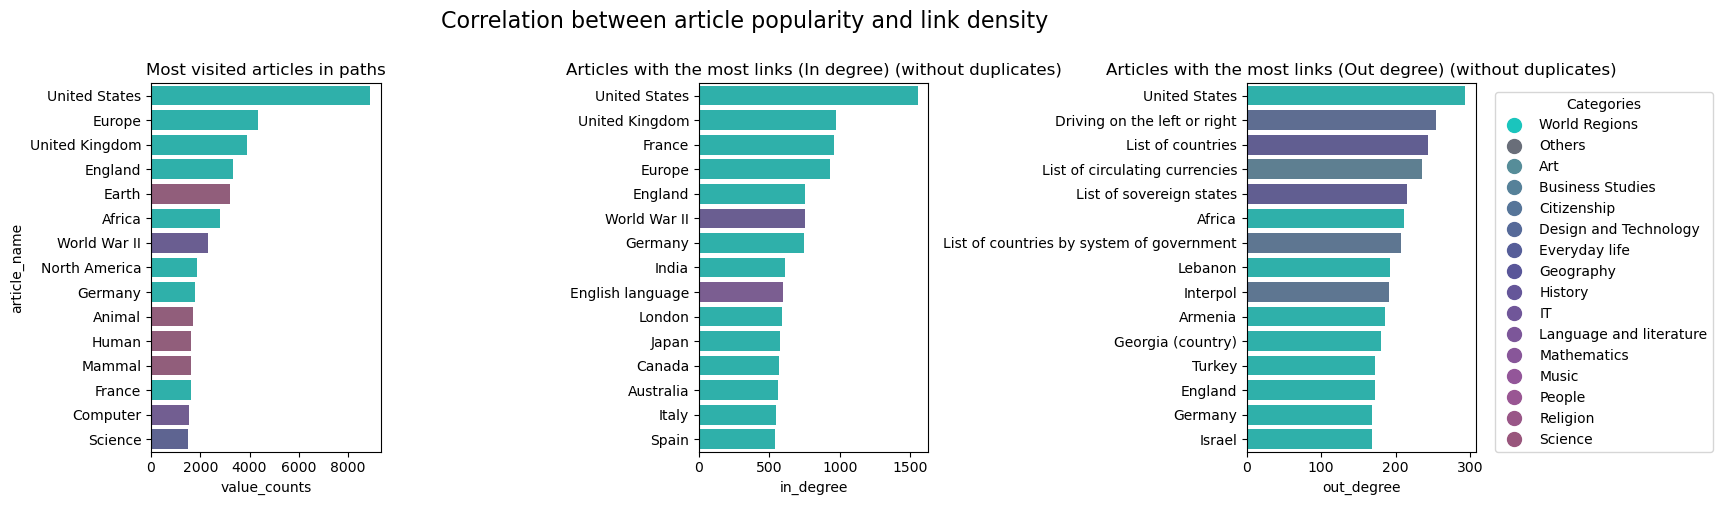

In [73]:
#TODO. comment + lists of countries in other categories
plot_article_popularity_link_density(df_article, df_finished, config.PALETTE_CATEGORY_DICT_COLORS, config.CATEGORY_ABBREVIATIONS, df_categories)

Results : We observe a significant overlap between the most visited articles and those with the highest degree. Additionally, the "Countries" category is prominently represented.

# 3. Analyse user behaviour (paths)

Let's look for patterns in user behaviour and try to understand how we could measure whether a game was difficult or not. Many different metrics can be considered, for instance:
- Game duration
- Game path length
- Difficulty rating given for finished paths
- Number of back-clicks needed
- Whether a game was finished or not
- For unfinished games, how the game was abandoned

A combination of these parameters can help finding in which games users struggled. This will then allow to assess whether players struggle less in <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than in other paths.

Let's first have a look of how the difficulty measures are distributed amongst each other for finished paths.

## 3.a Path duration

The median duration of finished paths is 107 seconds
The median duration of all unfinished paths is 261 seconds, among which :
  - The median duration of restart paths is 114 seconds
  - The median duration of timeout paths is 1864 seconds
Kurtosis of finished game durations: 3982.55
Kurtosis of restart game durations: 45.47
Kurtosis of timeout game durations: 136.67


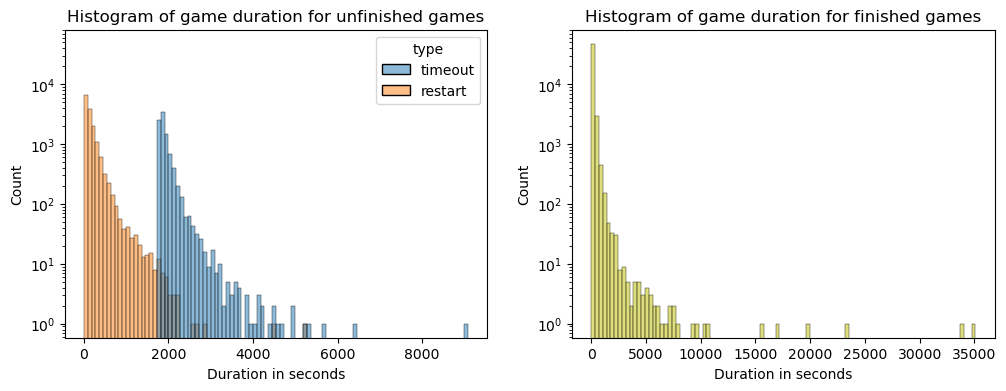

In [74]:
#TODO: keep code but not plot, not link to story

# Find medians and kurtosis for both finished and unfinished
median_finished = df_finished['durationInSec'].median()
kurtosis_finished = kurtosis(df_finished['durationInSec'])
median_unfinished = df_unfinished.groupby('type')['durationInSec'].median()
kurtosis_unfinished = df_unfinished.groupby('type')['durationInSec'].apply(kurtosis)

print(f"The median duration of finished paths is {median_finished:.0f} seconds")
print(f"The median duration of all unfinished paths is {df_unfinished['durationInSec'].median():.0f} seconds, among which :")
print(f"  - The median duration of restart paths is {median_unfinished['restart']:.0f} seconds")
print(f"  - The median duration of timeout paths is {median_unfinished['timeout']:.0f} seconds")

print(f"Kurtosis of finished game durations: {kurtosis_finished:.2f}")
print(f"Kurtosis of restart game durations: {kurtosis_unfinished['restart']:.2f}")
print(f"Kurtosis of timeout game durations: {kurtosis_unfinished['timeout']:.2f}")

# Plotting histograms
plt.figure(figsize=(12, 4))

# Unfinished games
ax1 = plt.subplot(121)
sn.histplot(df_unfinished, x='durationInSec', hue='type', bins=100)
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('Histogram of game duration for unfinished games')

# Finished games
plt.subplot(122, sharey=ax1)
sn.histplot(df_finished, x='durationInSec', bins=100, alpha=0.5, color='y')
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('Histogram of game duration for finished games')
plt.show()

Time-out paths are games where the player stopped playing for more that 30 minutes. If we set those aside, and look at the duration of paths where the players decided to restart a new game, the mediam duration of games is 114 seconds, approximately the same as finished path duration of 107 seconds.

The kurtosis in finished games is much higher than in unfinished restart games (3973 vs 45), meaning that finished games are more heavy tailed. We can in fact see very little players restart after 3000 seconds, whereas many finished games go beyond 6000. 

## 3.b Path duration and path length vs. user rating

Let's first look at path duration distribution over different user rating. We found similar results for finished and unfinished paths, so let's have a look at **finished ones** for example.

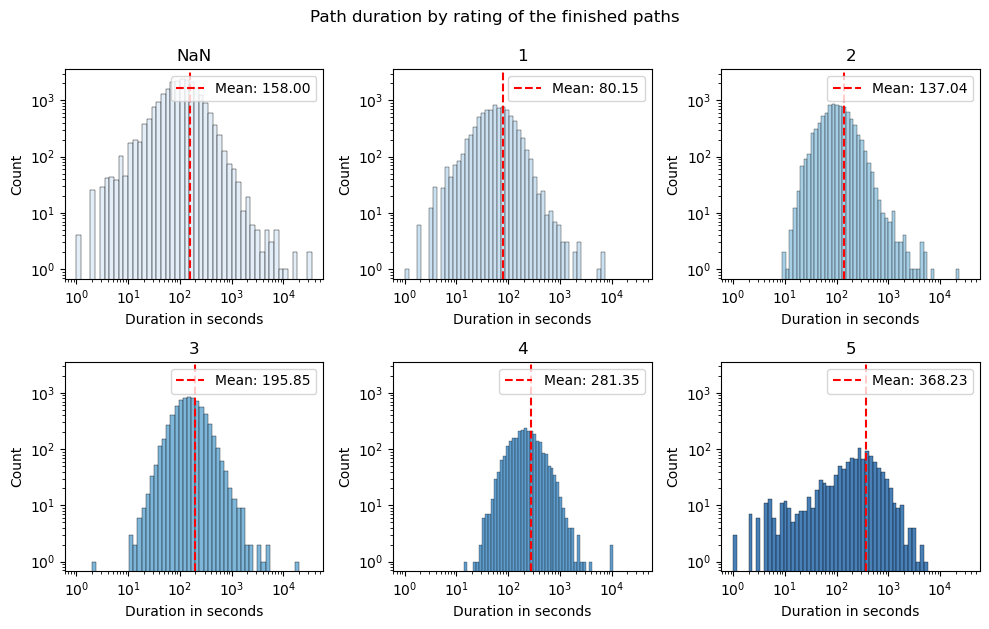

In [75]:
# change metric to 'path_length' for path length 
metric = 'durationInSec'

df_finished_strNaN = df_finished.copy()
df_finished_strNaN['rating'] = df_finished_strNaN['rating'].fillna('NaN')

plt.figure(figsize=(10, 6))
blues_palette = sn.color_palette("Blues", n_colors=6)

means, stds = [], []
ax1 = plt.subplot(231)
sn.histplot(df_finished[df_finished_strNaN['rating']=='NaN'], x=metric, bins=50, log_scale=True, color=blues_palette[0]) 
mean = df_finished[df_finished_strNaN['rating']=='NaN'][metric].mean()
plt.axvline(mean, color='red', label=f'Mean: {mean:.2f}', linestyle='--')
plt.yscale('log')
plt.xlabel('Duration in seconds')
plt.title('NaN')
plt.legend()

for i in range(1, 6):
    plt.subplot(231+i, sharex = ax1, sharey=ax1)
    sn.histplot(df_finished[df_finished_strNaN['rating']==i], x=metric, bins=50, log_scale=True, color=blues_palette[i])
    mean = df_finished[df_finished_strNaN['rating']==i][metric].mean()
    plt.axvline(mean, color="red", label=f'Mean: {mean:.2f}', linestyle='--')
    plt.yscale('log')
    plt.title(i)
    plt.xlabel('Duration in seconds')
    plt.legend()

plt.tight_layout()
plt.suptitle('Path duration by rating of the finished paths', y=1.04)
plt.show()

The distributions of the path duration by rating are nice log-normal distributions! This means we can use the mean (location) and standard deviation (scale) to characterise them. Indeed, except for NaN, there is a steady increase of the path duration mean when rating goes up.

Let's now look at whether path duration is correlated with path length:

In [76]:
df_path_stats_duration = pd.DataFrame()
df_path_stats_duration['mean'] = df_finished.groupby('rating', dropna=False)['durationInSec'].mean()
df_path_stats_duration['std'] = df_finished.groupby('rating', dropna=False)['durationInSec'].std()
df_path_stats_duration['sem'] = df_finished.groupby('rating', dropna=False)['durationInSec'].sem()

df_path_stats_length = pd.DataFrame()
df_path_stats_length['mean'] = df_finished.groupby('rating', dropna=False)['path_length'].mean()
df_path_stats_length['std'] = df_finished.groupby('rating', dropna=False)['path_length'].std()
df_path_stats_length['sem'] = df_finished.groupby('rating', dropna=False)['path_length'].sem()

df_path_stats = pd.concat([df_path_stats_duration, df_path_stats_length], axis=1, keys=['duration', 'length'])

df_path_stats

duration                            length                     
              mean         std        sem       mean        std       sem
rating                                                                   
1.0      80.150609  152.273618   1.648539   4.664909   2.052327  0.022219
2.0     137.036683  311.602204   3.325851   5.996355   2.432872  0.025967
3.0     195.847937  296.535832   3.483358   7.638057   3.699177  0.043454
4.0     281.351095  359.639492   6.870559  10.079927   5.871245  0.112164
5.0     368.231304  463.405289  13.665076  13.237391  17.200507  0.507215
NaN     158.002594  430.230937   2.852466   6.817486   4.030154  0.026720

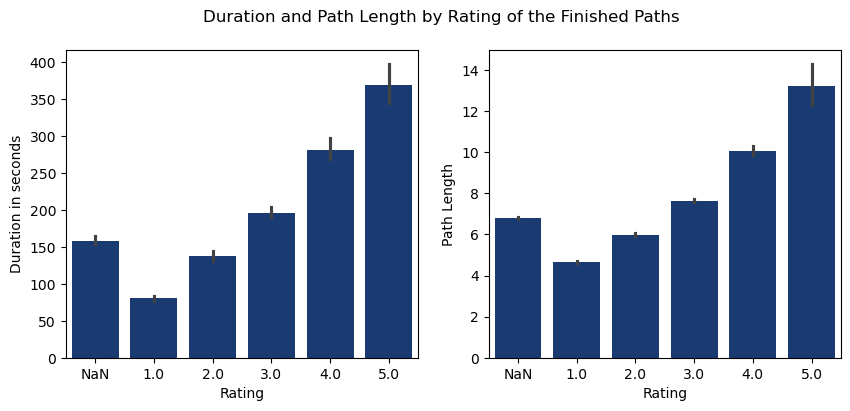

In [77]:
order = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']

plt.figure(figsize=(10, 4))
plt.subplot(121)
sn.barplot(df_finished_strNaN, x='rating', y='durationInSec', order=order, errorbar=('ci', 95), color='#0b3880')
plt.xlabel('Rating')
plt.ylabel('Duration in seconds')
plt.subplot(122)
sn.barplot(df_finished_strNaN, x='rating', y='path_length', order=order, errorbar=('ci', 95), color='#0b3880')
plt.suptitle('Duration and Path Length by Rating of the Finished Paths')
plt.xlabel('Rating')
plt.ylabel('Path Length')
plt.show()

There is a clear correlation between how long players took or how many clicks they made with the experienced difficulty rating. This means we can easily combine the two into a difficulty measure as they agree with each other on what players considered difficult. 

Let's now loow at back-clicks: could it indicate whether players had a hard time?

## 3.c Back-clicks
The number of back-clicks made in a game may indicate players getting stuck.
Lets investigate how this metric is related with player ratings, and if they are more prominent in certain categories:

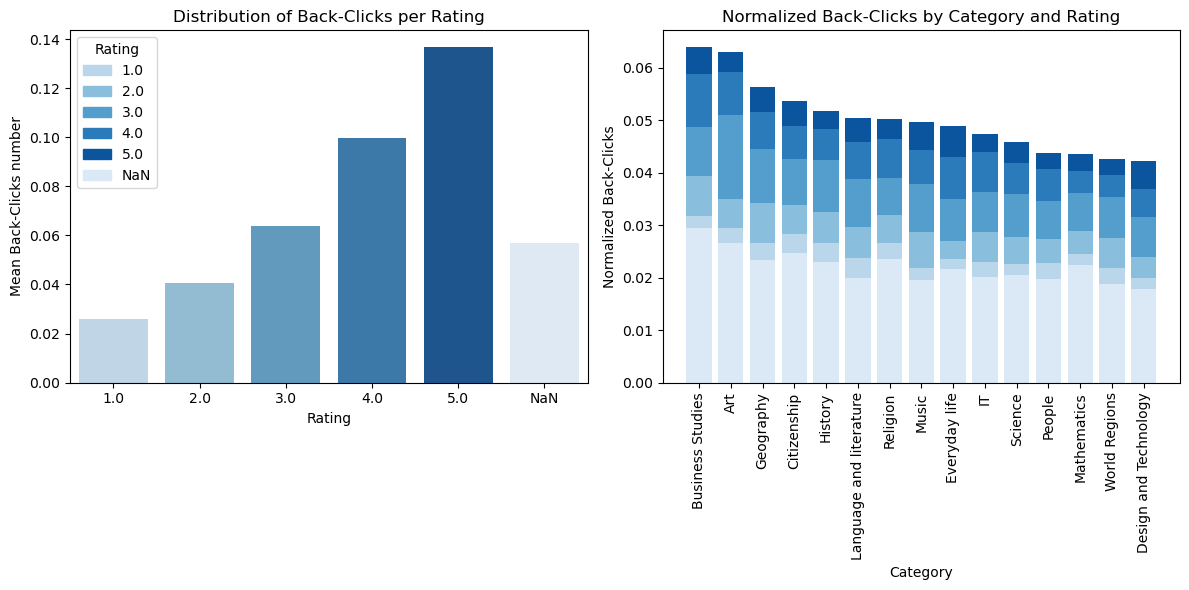

In [78]:
# Define color palette with NaN explicitly included
blues_palette = sn.color_palette("Blues", n_colors=6)
rating_order_plot1 = ['1.0', '2.0', '3.0', '4.0', '5.0', 'NaN']  # For Plot 1
rating_order_plot2 = ['NaN', '1.0', '2.0', '3.0', '4.0', '5.0']  # For Plot 2 (stacked bars)
# Map ratings to consistent colors
rating_colors = {rating: blues_palette[i] for i, rating in enumerate(rating_order_plot2)}

# Function to extract categories where back-clicks occurred using Transition Category Path
def extract_back_click_categories(category_path):
    back_click_categories = []
    for i, category in enumerate(category_path):
        if category == '<' and i > 0:  # Detect back-click and ensure valid index
            back_click_categories.append(category_path[i - 1])  # Use preceding category
    return back_click_categories

# Apply the function to identify back-click categories
df_finished['back_click_categories'] = df_finished['Transition Category Path'].apply(extract_back_click_categories)

# Explode back-click categories for analysis
df_back_clicks = df_finished.explode('back_click_categories').dropna(subset=['back_click_categories'])
df_back_clicks['rating'] = df_back_clicks['rating'].fillna('NaN')
df_back_clicks['rating'] = df_back_clicks['rating'].astype(str)

# Count total back-click occurrences grouped by category and rating
category_rating_back_click_counts = (df_back_clicks.groupby(['back_click_categories', 'rating']).size().reset_index(name='back_click_count'))

# Count total occurrences of each category in Category Path
category_total_occurrences = df_finished['Category Path'].explode().value_counts().reset_index()
category_total_occurrences.columns = ['Category', 'total_occurrences']

# Merge total occurrences into back-click data
category_rating_back_click_counts = pd.merge(category_rating_back_click_counts,category_total_occurrences.rename(columns={'Category': 'back_click_categories'}),on='back_click_categories',how='left')

# Normalize back-click counts by total occurrences
category_rating_back_click_counts['normalized_back_clicks'] = (category_rating_back_click_counts['back_click_count']/ category_rating_back_click_counts['total_occurrences'])
# Reorder both columns (ratings) and rows (categories)
df_pivot = category_rating_back_click_counts.pivot(index='back_click_categories', columns='rating', values='normalized_back_clicks').fillna(0)
df_pivot = df_pivot[rating_order_plot2].loc[df_pivot[rating_order_plot2].sum(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
# ---- Plot 1: Back-Clicks per Rating ----
back_per_rating = (
    df_finished.groupby("rating", dropna=False)
    .agg(mean_back_clicks=("back_clicks", "mean"), mean_path_length=("path_length", "mean"))
    .reset_index()
)
back_per_rating['rating'] = back_per_rating['rating'].fillna('NaN')
back_per_rating['normalized_back_clicks'] = back_per_rating["mean_back_clicks"] / back_per_rating["mean_path_length"]

# Plot 1 with shared colors
sn.barplot(data=back_per_rating,x="rating",hue="rating",y="normalized_back_clicks",palette=[rating_colors[r] for r in rating_order_plot1],ax=ax[0])
ax[0].set_title("Distribution of Back-Clicks per Rating")
ax[0].set_xlabel("Rating")
ax[0].set_ylabel("Mean Back-Clicks number")

# ---- Plot 2: Stacked bar plot for back-clicks by category and rating ----
bottom = pd.Series([0] * len(df_pivot), index=df_pivot.index)
for rating in rating_order_plot2:
    ax[1].bar(df_pivot.index,df_pivot[rating],bottom=bottom,label=f'Rating {rating}',color=rating_colors[rating])
    bottom += df_pivot[rating]

ax[1].set_title("Normalized Back-Clicks by Category and Rating")
ax[1].set_xlabel("Category")
ax[1].set_ylabel("Normalized Back-Clicks")
ax[1].tick_params(axis='x', rotation=90)

# ---- Shared Legend ----
handles = [plt.Rectangle((0, 0), 1, 1, color=rating_colors[rating]) for rating in rating_order_plot1]
ax[0].legend(handles, [f"{r}" for r in rating_order_plot1], title="Rating", loc='upper left')
plt.tight_layout()
plt.show()

TO ADAPT A LITTLE WITH NEW PLOT

The back-clicks are correlated with the difficulty rating, which is expected as the more difficult a game is, the more likely players are to get stuck and go back.
The category with the most back-clicks is "Art", and the one with the least is "Countries". This is interesting as "Countries" is also one of the most visited category, which might indicate that players are more familiar with it and therefore less likely to get stuck.
Additionaly, The distribution of rating inside each category seams quite similar.

In [79]:
plot_difficulties_voyage(df_finished, df_unfinished, config.PALETTE_CATEGORY_DICT_COLORS)

In [80]:
df_finished.groupby(["Wikispeedia_Voyage"])["back_clicks"].mean().reset_index()

Wikispeedia_Voyage  back_clicks
0               False     0.306303
1                True     0.536184

Voyage paths tend to be longer than non-voyage paths, with more back-clicks and a slightly higher rating. However, the percentage of completed games is higher for Voyages compared to Non-Voyages.

While World Regions articles are relatively few in number, they are highly prevalent within the network, often serving as key intermediate steps in paths. Although the 'Voyage' paths seem effective, they tend to be slower and less efficient overall. Is the popularity of these articles solely due to this? Could it be that users intentionally choose these articles? Further investigation is needed to explore this.

## 3.2.a Transitions between categories (Networks)

Here, we create a network *(directed graph)* to represent user transitions between different categories of articles.

- **Nodes:** Each node represents a group of articles belonging to a specific category, with each article assigned to his main category. 
- **Edges:** Each edge represents a transition from one article category to another, indicating the flow of user activity.

In this visualization, we exclude transitions within the same category (self-loops), as these are already represented in the transition matrix shown earlier (3.3.b). The focus here is on how users navigate between different categories.

The node positions are determined using a **force-directed algorithm**:

- Nodes repel each other like charged particles, preventing overlaps.
- Edges act like springs, pulling connected nodes closer to reflect their relationships.

----------


In the cell below, we recursively replace each back click **(<)** with the article that was visited prior to it. This ensures that we accurately reconstruct the original navigation path and correctly identify the corresponding category for each step and we use the merged df of paths as in this section we will first only analyse how users make moves between categories of articles, independ of their succes on the research.

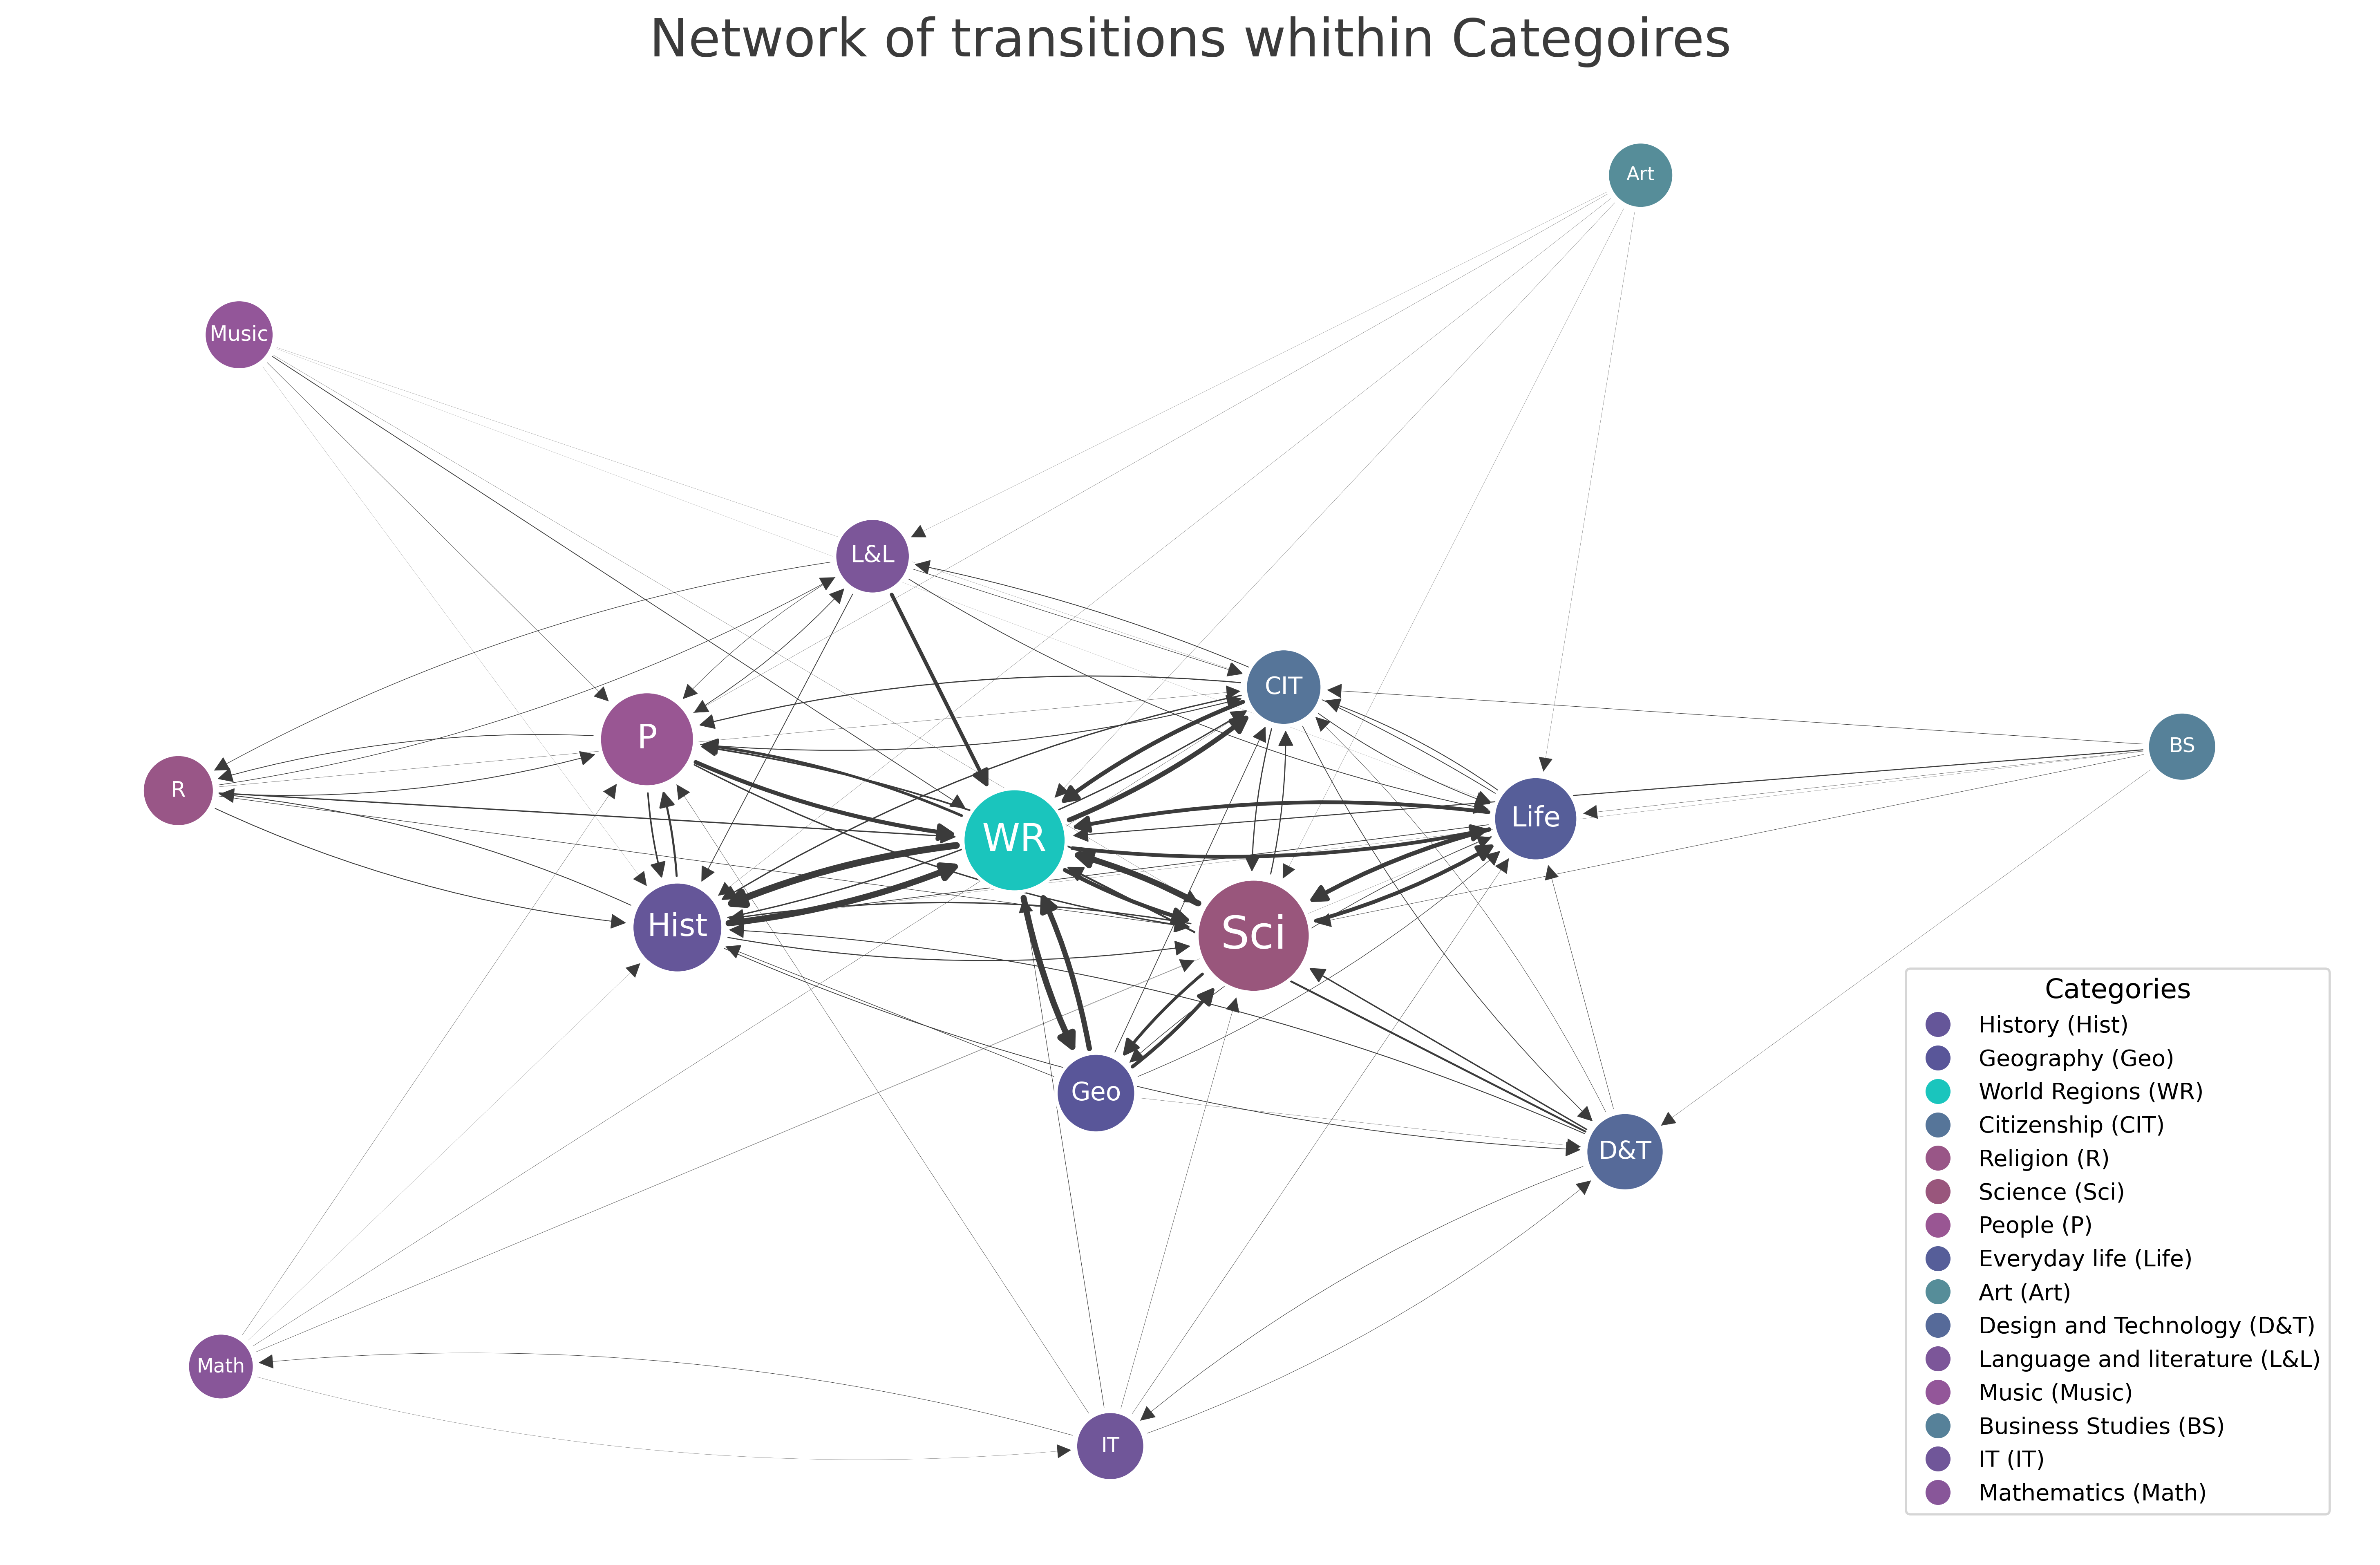

In [81]:
df_merged_no_backclick = df_merged['path'].apply(replace_back_clicks)
G = build_network(df_merged_no_backclick, df_categories, include_self_loops=False)
G = filter_network(G, weight_threshold=7, top_n=6)
plot_network(G, df_categories,palette=config.PALETTE_CATEGORY_DICT_COLORS, title="Network of transitions whithin Categoires", show_edge_labels=False, node_size=1000, node_abbreviations=config.CATEGORY_ABBREVIATIONS)

We observe a clustered graph, with central clusters dominated by categories containing the largest number of articles, such as Science, Geography, People, and History. Additionally, we see Countries positioned close to the center,despite the small size of the category (only 5% of the total articles) reflecting its strong connections with these major categories.

Next, we will normalize the edge weights by the total number of articles in the **source** category. This adjustment accounts for the imbalance in category sizes, ensuring a more accurate representation of transition dynamics.

**Note:** Currently, we are normalizing by the size of the source node only. However, for future analyses, we plan to explore other normalization methods, such as accounting for the size of the target category.

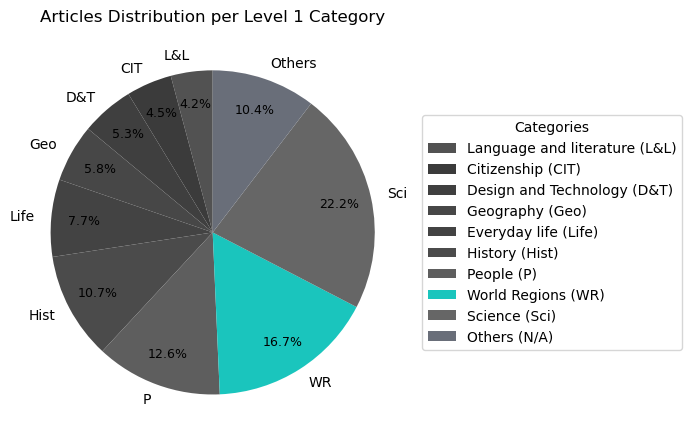

In [82]:
plot_articles_pie_chart(df_categories, config.PALETTE_CATEGORY_DICT, config.CATEGORY_ABBREVIATIONS)

Geography is both a category that many articles have and a category with high transitions. This needs to be further analysed to see if users really choose to go through Geography or if they are just more likely to find an article with that category. The same cannot be said for Countries, which is a much smaller category which still has high transition counts!

## 3.3 Comparison with optimal paths

Let's define the optimal path as the shortest path that can be taken. This assumption is coherent since the goal of the game is to reach the target while keeping the number of clicks as low as possible.

We can analyze whether users’ choice of categories aligns with the categories in the optimal path to determine if passing through 'World Regions' is an effective strategy for reaching the target.

To achieve this, we first need to compute the optimal path by constructing a directed graph where edges represent connections between articles. Here we take all the shortest possible paths per each combinaton of source-target present in the users' games. 

In [87]:
# Read precomputed optimal paths
optimal_paths = pd.read_pickle('data/paths-and-graph/optimal_paths.pkl')

Some combination of source and target have many possible shortest paths!

In [88]:
# Count the number of shortest paths for each (source, target) combination
path_counts = optimal_paths.groupby(['source', 'target']).size().reset_index(name='path_count')
path_counts.sort_values(by='path_count')

source                                   target  path_count
29977       Pink Pigeon  Canadian Charter of Rights and Freedoms           1
31315            Pyrite                                   Radish           1
31311            Pyrite                            Chromatophore           1
31309            Pyrite                             Ancient Rome           1
22382    Laurent Fignon                Tropical Storm Ana (2003)           1
...                 ...                                      ...         ...
26121            Mosaic                                  Silicon         419
31232            Puffin                           European Union         446
1388   Aircraft carrier                                  Vanilla         579
20578   James D. Watson                Chadian-Sudanese conflict         585
3695           Augustus                              Ununpentium         599

[42503 rows x 3 columns]

In [99]:
# Map the paths artciles to their categories
optimal_paths['Category Path'] = optimal_paths['path'].apply(lambda path: map_path_to_categories(path, category_map))

# Get users paths mapped to categories and remove backclicks
users_finished, users_unfinished = users_paths(df_finished, df_unfinished, category_map)

# Filter optimal paths to match source-target pairs in users paths and remove path where target available in source
optimal_fin, users_finished, optimal_unf, users_unfinished = filter_pairs(optimal_paths, users_finished, users_unfinished)

To compare user paths with optimal paths, we calculate the percentage of times each category is visited at each step for both datasets and each source-target association.

1. We can average the percentages by groupping them by source-target category pairs (e.g., source in 'Art' and target in 'Music'), then average within these groups to balance category representation. We can then visualize the categories taken at each of the first 10 steps.

2. To examine the difference between user and optimal paths in general trends, we average these percentages across steps for each category. Next, we compute the difference between the optimal and user paths for each source-target association and category. We then average these differences by groupping them by source-target category pairs.

In [269]:
S_T_opt_fin_percentages, S_T_fin_percentages, S_T_opt_unf_percentages, S_T_unf_percentages = calculate_step_percentages(optimal_fin, users_finished, optimal_unf, users_unfinished)

dataframes = [
    (S_T_opt_fin_percentages, 'opt'),
    (S_T_fin_percentages, 'fin'),
    (S_T_opt_unf_percentages, 'opt'),
    (S_T_unf_percentages, 'unf')
]

category_fin_means, category_unf_means=process_and_calculate_differences(dataframes, category_map, column_names=['source', 'target', 'categories'])

In [268]:
#TODO: warning
S_T_fin_percentages_norm_steps, S_T_opt_fin_percentages_norm_steps = process_percentages(S_T_opt_fin_percentages, S_T_fin_percentages, category_map, max_step=10)

/Users/mariannescoglio/Desktop/MA3/ADA/project/ada-2024-project-the5outliers/src/utils/helpers.py:857: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/mariannescoglio/Desktop/MA3/ADA/project/ada-2024-project-the5outliers/src/utils/helpers.py:858: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/mariannescoglio/Desktop/MA3/ADA/project/ada-2024-project-the5outliers/src/utils/helpers.py:859: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

This analysis applies to both finished and unfinished user paths. However, for easier visualization, we plot only finished paths at each step. The observed differences confirm that trends remain similar across both path types.

In [264]:
plot_position_line(S_T_fin_percentages_norm_steps, S_T_opt_fin_percentages_norm_steps, category_fin_means, category_unf_means, config.PALETTE_CATEGORY_DICT_COLORS)

In early path positions, the category 'World Regions' appears most frequently and consistently decreases over subsequent steps, aligning with other categories. This trend holds true for both optimal and user paths.

Note that, optimal paths are often very short. After the 5th step, only a few paths remain, which predominantly include categories like 'Citizenship', causing their percentages to increase sharply at the end.

The plot clearly shows that users pass through 'World Regions' less often than optimal paths suggest. This finding was surprising, as we intuitively expected humans to use more  <span style="background: linear-gradient(to right, #3458d6, #34d634); -webkit-background-clip: text; color: transparent;">Wikispeedia Voyages</span> than necessary. However, the opposite is true. Users might benefit from using this category more, likely because, as shown earlier, it is highly interconnected with other categories.

## 3.4 Comparison with random path

In [ ]:
df_paths = pd.concat([df_finished[['path', 'path_length']], df_unfinished[['path', 'path_length']]])

markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

print(f'Non-zero values of random transitions: {np.count_nonzero(markov_transitions)}')
print(f'Non-zero values of user transitions: {np.count_nonzero(user_transitions.to_numpy())}')

<div class="alert alert-block alert-info">

The transition matrix's $P$ left eigenvector with eigenvalue 1 (i.e. $x$ such that $xP=x$) is called the steady-state of the system. Let's call the normalised vector $x = (x_1, x_2, \dots, x_N)$, where the sum of all $x_i$ is 1. After $\infty$ iterations, starting from whatever article, the probability distribution of the end article is given by $x$. 

**Example**: For 3 articles, let's say that we have $x=(0.2, 0.3, 0.5)$. Then, when starting from any of the articles and taking infinitely many steps, there is probability 0.2 to be in article 1, probability 0.3 to be in article 2 and probability 0.5 to be in article 3.

</div>

In [ ]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=True)
ssb = compute_steady_state(markov_transitions, df_article_names, backclicks=True)
ssb.sort_values(by='steady_state_proportion', ascending=False).head(20)


In [ ]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
ss = compute_steady_state(markov_transitions, df_article_names)
ss.sort_values(by='steady_state_proportion', ascending=False).head(20)

<div class="alert alert-block alert-success">
There is indeed a vector with eigenvalue one, so there is a steady state in the system. To find the probabilities to be in a certain article in the steady state, we can look at the normalised values of the eigenvector. We see that United States is the most likely article to be in, followed mainly by a bunch of other countries.
</div>

<div class="alert alert-block alert-info">

#### Compare user vs random

Let's start in any article $i$ and take $l$ steps in the network, which leads to article $j$. The probability of this happening by chance in the network is simply $P_{ij}(l)=A^l_{ij}$. To get probabilities of transitions for every pair of articles and path length $l$, we only need to take the $l$-th power of the transition matrix! This effectively characterises the bias of the network itself: if users pass by an article A very often BUT that only by chance you end up on the same article often too, we cannot conclude that the user made that choice. 

To characterise the user choices, we simply take the paths they created by playing. We can then similarly create a transition matrix based on observed data: just take the aggregated count of all the transitions from all starting articles. For instance, from article $i$ we count 2 transitions to article $j_1$, 3 to $j_2$ and none to $j_3$. The normalised transition probabilities for article $i$ are then $(0.4, 0.6, 0)$. 

The difference in transition probabilities $\Delta P=(0.4, 0.6, 0) - (0.2, 0.3, 0.5) = (0.2, 0.3, -0.5) \in [-1, 1]^3$ then gives an idea of how likely it is that a user purposedly made a choice and not only ended in an article by accident. A highly positive value means that even though the transition is very unlikely in the network, the user made that choice. A larger negative value means that a user took a path that is rather unlikely under the random walk assumption. The Markov Chain allows to filter out the network bias in the user decisions.

<b>Note:</b> Maybe look into odds instead of probabilities to be more rigorous? https://stats.stackexchange.com/questions/22796/compare-the-difference-of-two-probabilities-or-a-ratio-of-probabilities

</div>

<div class="alert alert-block alert-success">

We can look at the difference between user games and random games at different steps of the game. This highlights the evolution of which articles palyers **voluntarily chose** to visit at different stages of the game. 
</div>

In [ ]:
KL = np.where((user_transitions > 0) & (markov_transitions > 0), user_transitions * np.log(user_transitions / markov_transitions), 0)
KL_df = pd.DataFrame(KL, columns=user_transitions.columns, index=user_transitions.index)
mean_KL = KL_df.mean(axis=0).sort_values(ascending=False)
mean_KL

In [ ]:
sn.heatmap(KL_df.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

In [ ]:
%%capture
mean_KL_step = get_step_divergences(df_article_names, parser, df_paths, backclicks=False)

In [ ]:
PALETTE_ARTICLE_DICT_COLORS = {}
for _, row in df_categories.iterrows():
    article = row['article']
    category = row['level_1']
    PALETTE_ARTICLE_DICT_COLORS[article] = config.PALETTE_CATEGORY_DICT.get(category, '#808080')

PALETTE_ARTICLE_DICT_COLORS['<'] = '#000000'

main_mean_div = mean_KL_step.iloc[:30]
fig_art = plot_article_step_divergence(main_mean_div, PALETTE_ARTICLE_DICT_COLORS)
fig_art.show()

In [ ]:
%%capture

KL_cat_df = get_step_divergences(df_article_names, parser, df_paths, df_categories=df_categories, backclicks=False)

In [ ]:
backclick_palette = config.PALETTE_CATEGORY_DICT_COLORS
backclick_palette['<'] = '#000000'
fig_cat = plot_category_step_divergence(KL_cat_df, backclick_palette)
fig_cat.show()

<div class="alert alert-block alert-success">

For the first transition, much more users go to United States or Europe than only following random transitions would.

<b>Notes:</b> 
- Values close to 0 means it is close to random behaviour. Values that are closer to -1 or 1 are the special behaviour, either clicking much more or much less on certain articles than random would predict.
- How could we remove the link position bias? Maybe check if certain links are on the top/bottom of the page and give more or less importance accordingly?
- Does adding backclicks as in the function above make sense?
</div>

### Categories normalised by transition probabilities

In [ ]:
from collections import Counter
from src.utils.helpers import map_path_to_categories

markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False, normalise=False)
article_to_category = dict(zip(df_categories['article'], df_categories['level_1']))
mapped_categories = map_path_to_categories(df_article_names, article_to_category)
transitions_per_category = pd.DataFrame({'category': mapped_categories, 'transition': markov_transitions.sum(axis=1)})
transitions_per_category=transitions_per_category.groupby('category', as_index=False).sum()
category_counts = Counter(mapped_categories)
category_counts_df = pd.DataFrame(category_counts.items(), columns=['category', 'count'])

result = pd.merge(category_counts_df , transitions_per_category, on='category')
result['ratio'] =  result['transition'] / result['count']
result = result.sort_values(by='ratio')

sn.barplot(data=result, x='category', y='ratio', hue='category', legend=None, palette='viridis')

# Customize the plot
plt.xlabel('Category')
plt.ylabel('Transitions / # Articles in Category')
plt.title('Ratio of Count to Transitions by Category')
plt.xticks(rotation=90) 
plt.show()

### Page structure

In [ ]:
# where are link to a certain category in a page ?
link_per_cat = find_category_position_articles(parser, df_categories, config.CATEGORIES_OTHERS)
df = pd.DataFrame(link_per_cat)
df.describe()

In [ ]:
# Where do people click on an article page ?
df_merged = location_click_on_page(df_merged, parser)

In [ ]:
# put that in a function

df_merged["category"] = "All"
df_merged["Legend :"] = "Clicked Link Position in Paths"
df_melted = pd.melt(df, var_name='category', value_name='position').dropna()
df_melted["Legend :"] = "Article Link Position in Articles"
df_comparison_path_category = pd.concat([df_merged[["category", "position", "Legend :"]], df_melted])

fig = px.box(df_comparison_path_category, x="category", y="position", color="Legend :", title="Position of the clicked link in articles compared to position of each category in articles")
fig.update_xaxes(tickangle=45)

fig.update_layout(
    autosize=False,
    width=1500,
    height=500,
    boxgroupgap=0.2, # update
    boxgap=0)
fig.show()

# 4. Methods for Further Analysis
This section aims to show a few of the tools that will be useful along the way for our project. Instead of using them to answer our final question, we use them on the dataset as a whole to show that interesting information can be extracted from these methods.

We can clearly see that the reordered article indices make intuitive sense, similar words are regrouped. Words in the clusters with high similarity (similarity > 0.5) are words that appear more often in natural language, while words in the low-similarity areas are similar one to another, but not commonly used. This shows that we can regroup articles in clusters of 'well-known words' that are likely more present on user paths.

## 4.2. Evolution of similarity on paths
Now that we established similarity as a metric, can we see how mean similarity evolves on paths in general? Do we observe that users quickly try to leave a category in the first few clicks? Later this will be used to assess whether there is a difference for voyages and non-voyages, and whether there is a difference depending on the categories the path in made of, but for now this already gives an insight into what we can expect.

In [ ]:
#TODO: test si interessant avec voyages, check with jaccard, add to camille results, could check other embedding

all_finished_paths = [replace_back_clicks(path).split(';') for path in df_finished['path'].tolist()]
path_similarities = []

for path in all_finished_paths:
    path_similarity = []
    for step in range(len(path)-1):
        current, next = path[step], path[step+1]
        path_similarity.append(df_sm[current][next])

    path_similarities.append(path_similarity)

Here is an example to understand what is going on. Each point represents a click of a user, to go from the first page (Batman) to the next (Chemistry). Batman and Chemistry are not strongly semantically related (hence the relatively low value of about 0.4). In the next step to Biology, the similarity is much higher (about 0.7), so the player first leave the category to reach the target category and then tends to stay there.

In [ ]:
path_id = 1829
path = path_similarities[path_id]
plt.plot(range(len(path)), path, marker='o', color='#0c8714')
plt.xticks([i-0.5 for i in range(len(path)+1)], all_finished_paths[path_id], rotation=90)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
len_N_path_similarity = {}
for path_sim in path_similarities:
    path_length = len(path_sim)
    len_N_path_similarity.setdefault(path_length, []).append(path_sim)

len_N_mean_similarity = {paths_len: np.mean(paths, axis=0) for paths_len, paths in len_N_path_similarity.items()}

In [ ]:
plt.figure(figsize=(7, 5))
greens_palette = sn.light_palette("#0c8714", n_colors=10)

for i in range(1, 11):
    sn.lineplot(len_N_mean_similarity[i+1], lw=1, label=i, color=greens_palette[i-1])
plt.legend(title='# Link Clicks')
plt.xlabel("Position of the Click in the Players' Paths")
plt.xticks(range(0, 11))
plt.ylabel('Mean Semantic Similarity')
plt.title('Mean Semantic Similarity Difference Aggregated by Path Lenghts')
plt.tight_layout()
plt.show()

There is a clear trend: in the first few clicks, the articles chosen have a low similarity to the previous one: this can be interpreted as leaving the original category. After this, the similarity for the next clicks stabilises, with only small fluctuations.